In [8]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
import PyKDL as kdl
import kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb

In [9]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 


def g_kdl_func():
    for j in range(njoints):
        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    kdl.ChainDynParam(kdlmodel, gravity_kdl).JntToCoriolis(q_kdl, qdot_kdl, g_kdl)


def g_u2c_func():   
    for j in range(njoints):
        q_none = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    g_u2c(q_none, qdot_none)
    
def g_pb_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    g_pb = pb.calculateInverseDynamics(pbmodel, q_none, qdot_none, qddot)
    
def g_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.NonlinearEffects(rbdlmodel, q_np, qdot_np, g_rbdl)

In [17]:
#pbmodel = pb.loadURDF("pantilt.urdf")
sim = pb.connect(pb.DIRECT)
#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 60
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data
mediantime_kdl = [None]*ndofs
mediantime_u2c = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_pb = [None]*ndofs
mintime_kdl = [None]*ndofs
mintime_u2c = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_pb = [None]*ndofs
averagetime_kdl = [None]*ndofs
averagetime_u2c = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_pb = [None]*ndofs

nitr = 1000
nrepeat = 100
    
for i in range(ndofs):    
    print i
    path_to_urdf = "/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    #path_to_urdf = str(urdf_nr[i]) + "dof.urdf"
    end_link = "link" + str(urdf_nr[i])
    root = 'base_link'
    tip = end_link
    
    ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf)
    pbmodel = pb.loadURDF(path_to_urdf, useFixedBase=True, flags = pb.URDF_USE_INERTIA_FROM_FILE)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = len(jlist)

    gravity_kdl = kdl.Vector()
    gravity_kdl[2] = -9.81
    gravity_u2c = [0, 0, -9.81]
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    g_rbdl = np.zeros(njoints)
    
    #kdl declatations
    q_kdl = kdl.JntArray(njoints)
    qdot_kdl = kdl.JntArray(njoints)
    g_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    qdot_none = [None]*njoints
    g_pb = [None]*njoints
    
    qddot = []
    for i in range(njoints):
        qddot.append(0.)
        
    #qdot = []
    #for i in range(njoints):
    #    qdot.append(0.)
    
    g_u2c = asd.get_coriolis_rnea(root, tip)
    timeit_u2c = repeat("g_u2c_func()", setup = "from __main__ import g_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c[i] = min(timeit_u2c)
    mediantime_u2c[i] = median(timeit_u2c)
    averagetime_u2c[i] = average(timeit_u2c)
    
    timeit_pb = repeat("g_pb_func()", setup = "from __main__ import g_pb_func", repeat = nrepeat, number = nitr)
    mintime_pb[i] = min(timeit_pb)
    mediantime_pb[i] = median(timeit_pb)
    averagetime_pb[i] = average(timeit_pb)
    
    timeit_rbdl = repeat("g_rbdl_func()", setup = "from __main__ import g_rbdl_func", repeat = nrepeat, number = nitr)
    mintime_rbdl[i] = min(timeit_rbdl)
    mediantime_rbdl[i] = median(timeit_rbdl)
    averagetime_rbdl[i] = average(timeit_rbdl)
    
    timeit_kdl = repeat("g_kdl_func()", setup = "from __main__ import g_kdl_func", repeat = nrepeat, number = nitr)
    mintime_kdl[i] = min(timeit_kdl)
    mediantime_kdl[i] = median(timeit_kdl)
    averagetime_kdl[i] = average(timeit_kdl)


0
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/1dof.urdf
1
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/2dof.urdf
2
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/3dof.urdf
3
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/4dof.urdf
4
The root l

33
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/34dof.urdf
34
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/35dof.urdf
35
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/36dof.urdf
36
The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/37dof.urdf
37
T

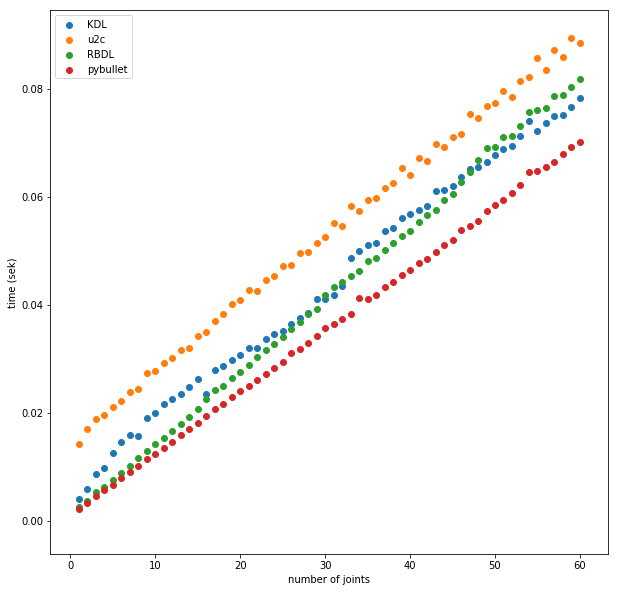

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (10, 10))
plt.scatter(joint_nr, mediantime_kdl, label='KDL')
#plt.scatter(joint_nr, mediantime_u2c, c='hotpink', label='u2c')
plt.scatter(joint_nr, mediantime_u2c, label='u2c')
plt.scatter(joint_nr, mediantime_rbdl, label='RBDL')
plt.scatter(joint_nr, mediantime_pb, label='pybullet')
plt.xlabel("number of joints")
plt.ylabel("time (sek)")
plt.legend(loc='upper left')
med_fig.show()

[Text(0,0,'pybullet'), Text(0,0,'RBDL'), Text(0,0,'U2C'), Text(0,0,'KDL')]

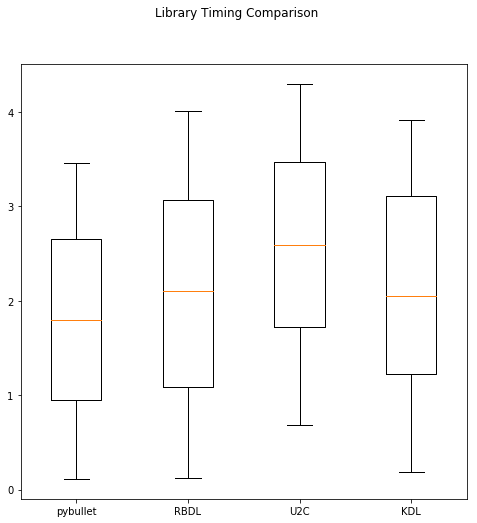

In [6]:
timing_scores = [mediantime_pb, mediantime_rbdl, mediantime_u2c, mediantime_kdl]
names = ["pybullet", "RBDL", "U2C", "KDL"]#, "RBDL", "pybullet"]
boxplot = plt.figure(figsize = (8, 8))
boxplot.suptitle("Library Timing Comparison")
ax = boxplot.add_subplot(111)
ax.boxplot(timing_scores)
#plt.boxplot(timing_scores)
ax.set_xticklabels(names)


In [16]:
print "mediantime_u2c = ",mediantime_u2c

print "mediantime_kdl = ",mediantime_kdl

print "mediantime_rbdl = ",mediantime_rbdl

print "mediantime_pb = ",mediantime_pb

mediantime_u2c =  [0.014296412467956543, 0.016957998275756836, 0.01802957057952881, 0.019240379333496094, 0.02075815200805664, 0.021791577339172363, 0.0233004093170166, 0.024242520332336426, 0.025767087936401367, 0.02738189697265625, 0.028478503227233887, 0.029804587364196777, 0.03092658519744873, 0.03200244903564453, 0.033260345458984375, 0.03480052947998047, 0.03632700443267822, 0.037753939628601074, 0.03895151615142822, 0.04015457630157471, 0.041544556617736816, 0.04240107536315918, 0.0437084436416626, 0.04510855674743652, 0.04601442813873291, 0.047948479652404785, 0.04912996292114258, 0.049921512603759766, 0.05187404155731201, 0.052115559577941895, 0.05337488651275635, 0.054242491722106934, 0.056156158447265625, 0.05739188194274902, 0.058060526847839355, 0.059324026107788086, 0.060202956199645996, 0.062482476234436035, 0.06305062770843506, 0.06428384780883789, 0.06547749042510986, 0.06659603118896484, 0.06758034229278564, 0.0690540075302124, 0.07073462009429932, 0.07143855094909668